In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
_ = torch.manual_seed(42)

from sbi.analysis import pairplot
from sbi.utils import BoxUniform
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

from model import SocialGPModelSBI
from rewards import sample_children_with_corr

In [4]:
import numpy
print(numpy.__version__)

2.3.1


In [5]:
seed = 0
rng: np.random.Generator = np.random.default_rng(seed)

In [6]:
rho_child_child = 0.6
_, child_maps = sample_children_with_corr(
            rng=rng,
            n_children=4,
            length_scale=2.0,
            rho_parent_child=rho_child_child,
            rho_child_child=rho_child_child,
            tol=0.1,
            max_tries=1000
        )

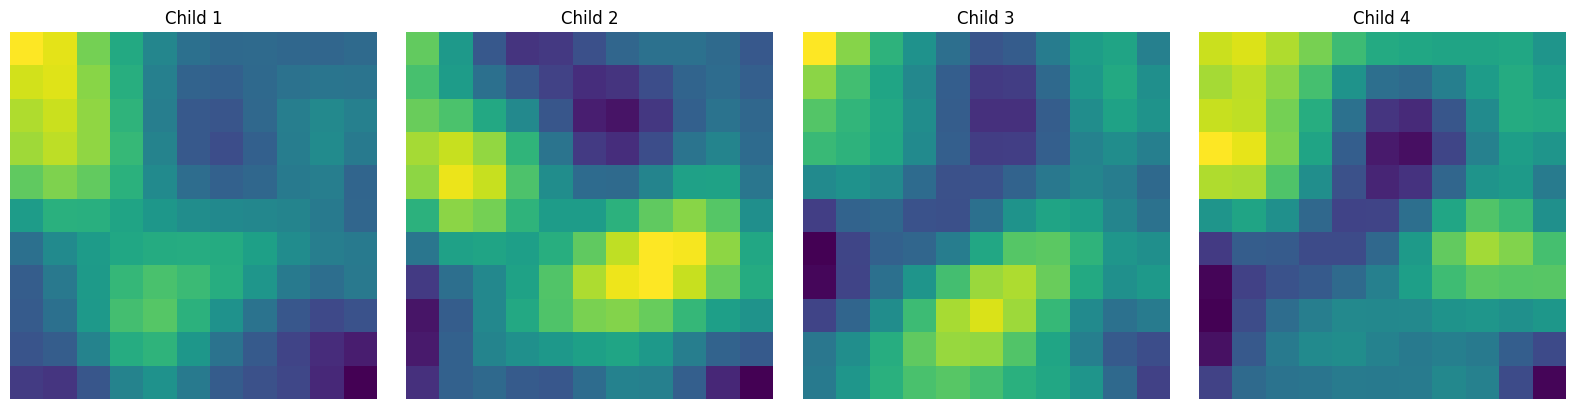

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns

for i, (c, ax) in enumerate(zip(child_maps, axes)):
    ax.imshow(c)
    ax.set_title(f"Child {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

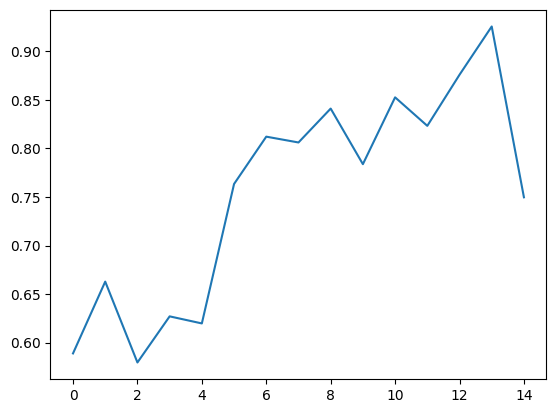

In [8]:
m = SocialGPModelSBI(child_maps, rng=rng, length_scale=1.11, observation_noise_private=0.0001, observation_noise_social=3, tau=0.03, beta=0.33)

for _ in range(15):
    m.step()
plt.plot(m.datacollector.get_model_vars_dataframe()['avg_reward']);

## Prior

In [10]:
# length_scale, observation_noise_social, beta, tau
lb = [0.5, 0.0001, 0.05, 0.01]
up = [3.0, 20, 1.0, 0.05]
limits = list(zip(lb, up))
lower_bound = torch.as_tensor(lb)
upper_bound = torch.as_tensor(up)
prior = BoxUniform(low=lower_bound, high=upper_bound)
prior

BoxUniform(Uniform(low: torch.Size([4]), high: torch.Size([4])), 1)

In [262]:
theta = prior.sample((10_000,))
theta

tensor([[2.4979e+00, 1.6140e+01, 2.5688e-01, 4.9201e-02],
        [1.2153e+00, 1.6152e+00, 1.2630e-01, 4.4720e-02],
        [1.6606e+00, 1.0185e+01, 1.2740e-01, 4.7727e-02],
        ...,
        [9.7336e-01, 1.8436e+01, 5.5513e-01, 4.1246e-02],
        [2.4356e+00, 3.6874e+00, 3.5560e-01, 1.7972e-02],
        [1.3909e+00, 1.5811e+01, 2.7600e-01, 3.9021e-02]])

## Simulate function

In [263]:
def simulate(parameters):
    rho_child_child = 0.6
    repetitions = []
    for _ in range(5):
        _, child_maps = sample_children_with_corr(
                    rng=None,
                    n_children=4,
                    length_scale=2.0,
                    rho_parent_child=rho_child_child,
                    rho_child_child=rho_child_child,
                    tol=0.1,
                    max_tries=1000
                )
        # print(child_maps[0][0, 0], child_maps[1][0, 0], child_maps[2][0, 0])
    
        for _ in range(10):
            _model = SocialGPModelSBI(
                child_maps, 
                rng=None,
                length_scale=parameters[0], 
                observation_noise_private=0.0001,
                observation_noise_social=parameters[1],
                beta=parameters[2],
                tau=parameters[3]
            )
        
            for _ in range(15):
                _model.step()
            results = _model.datacollector.get_model_vars_dataframe()
            repetitions.append(results.loc[:, "avg_reward"].to_numpy())
    
    return np.mean(repetitions, axis=0)


In [264]:
def parallel_simulate(theta):
    # Our simulator uses numpy, but prior samples are in PyTorch.
    theta_np = theta.numpy()

    num_workers = 8
    simulation_outputs = Parallel(n_jobs=num_workers, verbose=0)(
        delayed(simulate)(batch)
        for batch in theta_np
    )
    return np.asarray(simulation_outputs)


In [265]:
%%time
simulation_outputs = parallel_simulate(theta)

/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desired correlations within 1000 attempts (tol=0.1). Using the last draw.
  warnings.warn(
/Users/valery/Library/Caches/pypoetry/virtualenvs/spatial-mab-abm-icOMRY7y-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desired correlations within 1000 attempts (tol=0.1). Using the last draw.
  warnings.warn(
/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desired correlations within 1000 attempts (tol=0.1). Using the last draw.
  warnings.warn(
/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desi

CPU times: user 37.9 s, sys: 8.12 s, total: 46 s
Wall time: 1h 13min 4s


In [266]:
simulation_outputs.shape

(10000, 15)

In [267]:
df = pd.DataFrame(simulation_outputs)

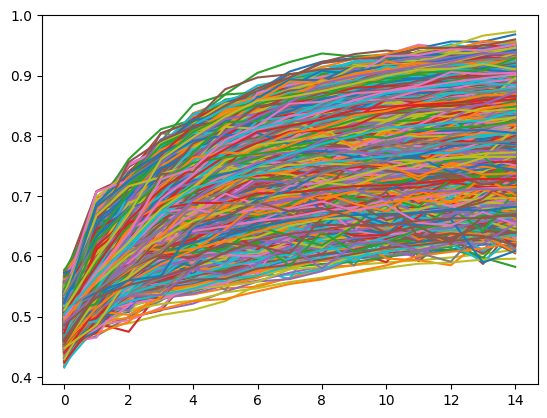

In [268]:
plt.plot(simulation_outputs.T);

<Axes: xlabel='variable', ylabel='value'>

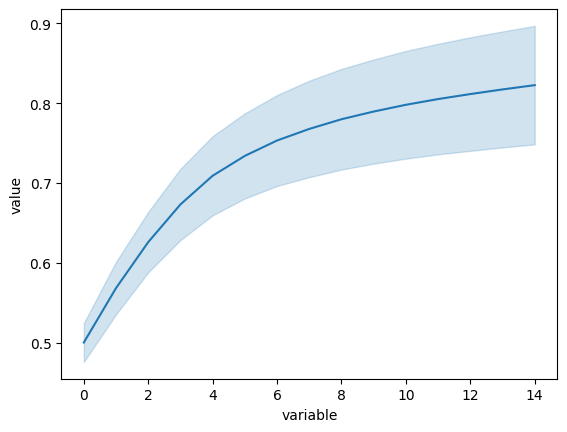

In [269]:
sns.lineplot(df.melt(), x="variable", y="value", errorbar="sd")

In [270]:
x = torch.as_tensor(simulation_outputs, dtype=torch.float32)

In [271]:
x.shape

torch.Size([10000, 15])

## Neural Posterior Estimation (NPE)

In [272]:
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding

embedding_net = FCEmbedding(input_dim=15, output_dim=5)
# model="nsf"
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

# inference = NPE(density_estimator="nsf")
inference = NPE(prior=prior, density_estimator=neural_posterior)

In [273]:
%%time
posterior_net = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 260 epochs.CPU times: user 5min 4s, sys: 22.4 s, total: 5min 26s
Wall time: 1min 31s


For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/valery/SIOI/Spatial-MAB-ABM/abm/sbi-logs/NPE_C/2025-06-25T21_35_16.938352' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


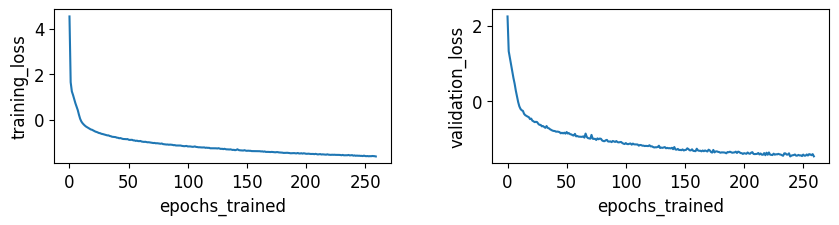

In [274]:
from sbi.analysis import plot_summary
_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

In [275]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


## Inferring the Posterior

In [276]:
subj_data_all = pd.read_csv("data/e1_data.csv")

In [277]:
subj_data_all[['group', 'agent', 'trial', 'round', 'scaling', 'choice', 'isRandom', 'reward', 'payoff', 'rescaled']]
# subj_data_all[['reward', 'payoff', 'rescaled']].hist(bins=100);

,group,agent,trial,round,scaling,choice,isRandom,reward,payoff,rescaled
0,0,1,0,0,64,97,1,0.2540,25,21
1,0,1,1,0,64,6,1,0.8249,81,57
2,0,1,2,0,64,23,0,0.6730,69,49
3,0,1,3,0,64,57,1,0.0500,0,5
4,0,1,4,0,64,16,0,0.9155,92,64
...,...,...,...,...,...,...,...,...,...,...
15355,45,4,10,7,67,50,0,0.9720,97,70
15356,45,4,11,7,67,40,0,0.8675,88,64
15357,45,4,12,7,67,48,0,0.8532,85,62
15358,45,4,13,7,67,39,0,0.8978,90,65


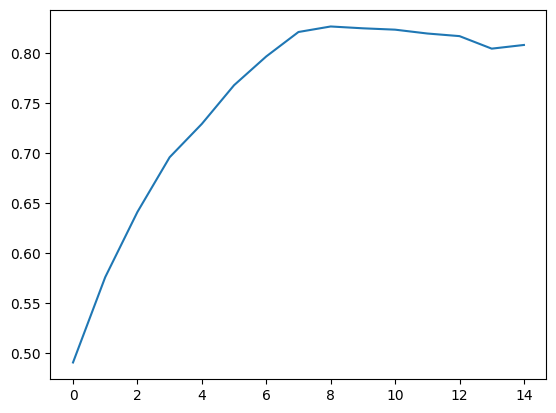

In [278]:
x_obs = subj_data_all.groupby(["trial"])["reward"].mean()
plt.plot(x_obs);

In [330]:
samples = posterior.sample((1_000_000,), x=x_obs)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

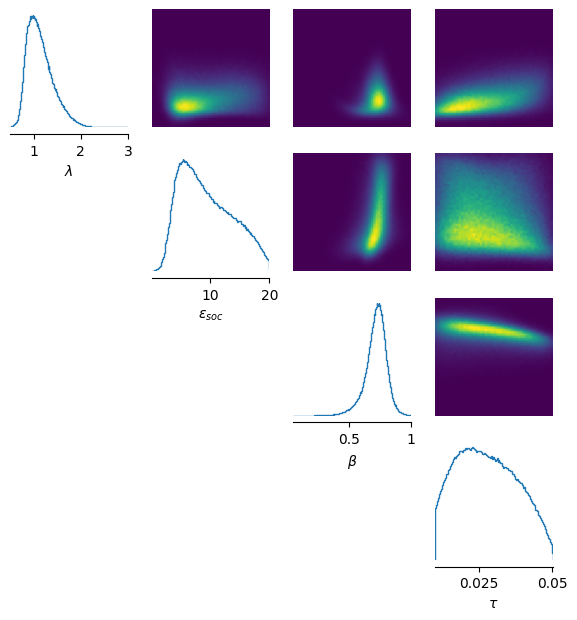

In [280]:
_ = pairplot(
    [samples],  # theta,
    limits=limits,
    # ticks=[[0, 5], [-1, 20], [0, 1], [0, 0.05]],
    # ticks=[[0.05, 0.2], [0.01, 0.05], [0.005, 0.05], [0.005, 0.2]],
    # points=[[1.11, 12, 0.33, 0.03], [1.4, 18, 0.15, 0.015]],  # , [2, 0.55, 0.2, 0.007]
    figsize=(7, 7),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
)

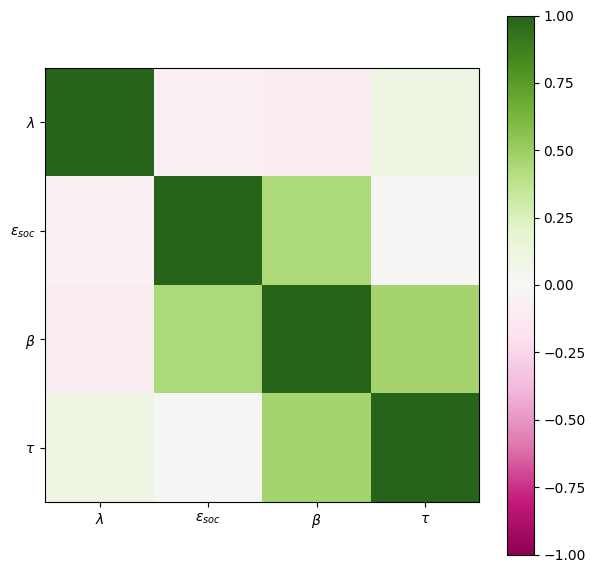

In [307]:
corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap="PiYG")
plt.xticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
plt.yticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
_ = fig.colorbar(im)

## Analysing variability and compensation mechanisms

In [303]:
from sbi.analysis import (
    conditional_corrcoeff,
    conditional_pairplot,
    conditional_potential,
    pairplot,
)
from sbi.inference import (
    MCMCPosterior,
    posterior_estimator_based_potential,
)


In [304]:
posterior.set_default_x(x_obs)

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

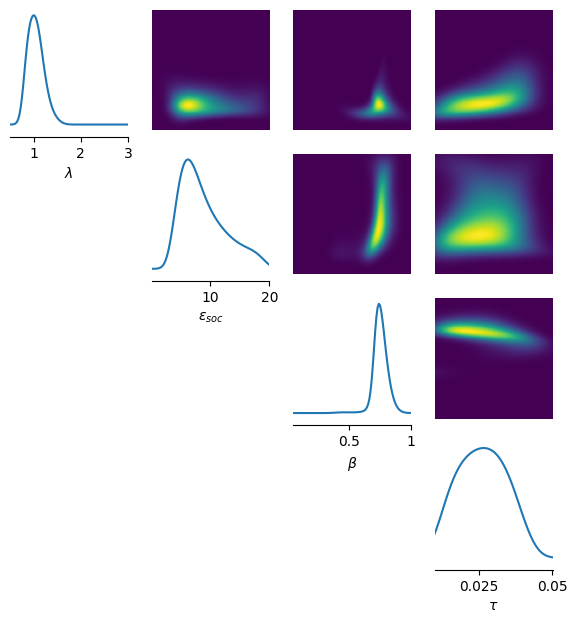

In [332]:
# cond1 = [1.11, 12, 0.33, 0.03]
# cond1 = [1.048, 7.427, 0.719, 0.021]
cond1 = [1.048, 7.427, 0.719, 0.021]

_ = conditional_pairplot(
    density=posterior,
    resolution=100,
    condition=torch.as_tensor([cond1]),  # [1.11, 3, 0.33, 0.03]
    limits=limits,
    # points=[[1.4, 9, 0.1, 0.006], [2.4, 9, 0.2, 0.006]],  # , [2, 0.55, 0.2, 0.007]  # [1.11, 12, 0.33, 0.03]
    figsize=(7, 7),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
)


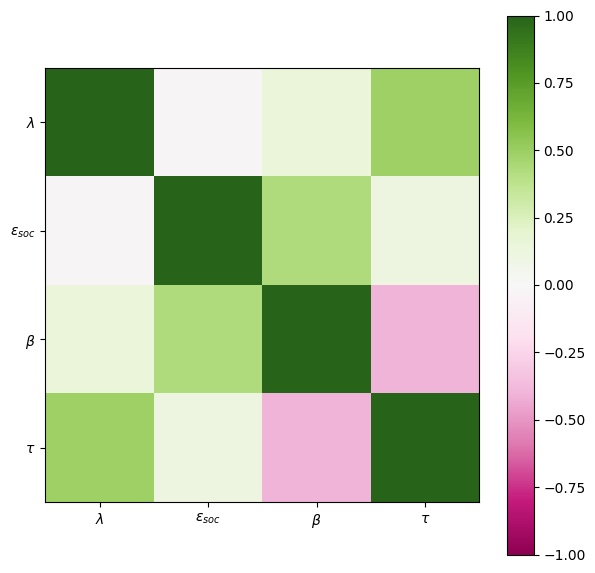

In [333]:
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=torch.as_tensor([cond1]),  # [1.11, 3, 0.33, 0.03]
    limits=torch.tensor(limits),
)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap="PiYG")
plt.xticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
plt.yticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
_ = fig.colorbar(im)

### Sampling conditional distributions

In [308]:
potential_fn, theta_transform = posterior_estimator_based_potential(
    posterior_net, prior=prior, x_o=x_obs
)

In [309]:
conditioned_potential_fn, restricted_tf, restricted_prior = conditional_potential(
    potential_fn=potential_fn,
    theta_transform=theta_transform,
    prior=prior,
    # condition=torch.as_tensor(
    #     [1.11, 9.5, 0, 0]
    # ),
    # dims_to_sample=[2, 3],
    # condition=torch.as_tensor(
    #     [1.11, 12.0, 0.0, 0.0]
    # ),
    # dims_to_sample=[2, 3],
    condition=torch.as_tensor(
        [0.0, 0.0, 0.33, 0.03]
    ),
    dims_to_sample=[0, 1],
)

In [310]:
mcmc_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=restricted_tf,
    proposal=restricted_prior,
    method="slice_np_vectorized",
    num_chains=20,
).set_default_x(x_obs)
cond_samples = mcmc_posterior.sample((100_000,))

/Users/valery/Library/Caches/pypoetry/virtualenvs/spatial-mab-abm-icOMRY7y-py3.12/lib/python3.12/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/105000 [00:00<?, ?it/s]

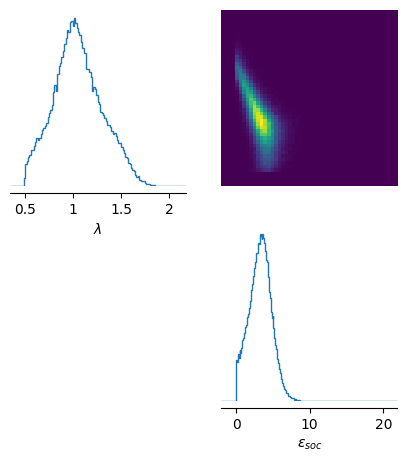

In [312]:
pairplot(cond_samples, figsize=(5, 5), 
         diag_kwargs=dict(bins="auto"),
         # labels=["$\\beta$", "$\\tau$"]
         labels=["$\\lambda$", "$\\epsilon_{soc}$"]
        );

In [313]:
conditioned_potential_fn, restricted_tf, restricted_prior = conditional_potential(
    potential_fn=potential_fn,
    theta_transform=theta_transform,
    prior=prior,
    condition=torch.as_tensor(
        [1.11, 0.0, 0.33, 0.03]
    ),  # the first n values are arbitrary and are ignored internally
    dims_to_sample=[1],
)

In [314]:
mcmc_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=restricted_tf,
    proposal=restricted_prior,
    method="slice_np_vectorized",
    num_chains=20,
).set_default_x(x_obs)
cond_samples = mcmc_posterior.sample((50_000,))

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/55000 [00:00<?, ?it/s]

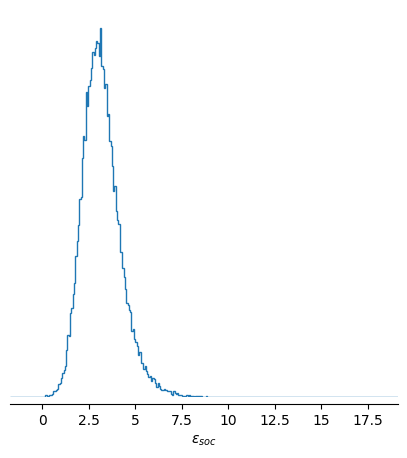

In [316]:
pairplot(cond_samples, figsize=(5, 5), diag_kwargs=dict(bins="auto"), labels=["$\\epsilon_{soc}$"]);

## Train again using samples from posterior

In [54]:
samples.shape

torch.Size([1000000, 4])

In [55]:
simulation_outputs2 = parallel_simulate(samples[:10_000, :])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 296 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 796 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 1496 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Done 2396 tasks      | elapsed:   32.1s
[Parallel(n_jobs=8)]: Done 3496 tasks      | elapsed:   45.2s
/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desired correlations within 1000 attempts (tol=0.1). Using the last draw.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 4796 tasks      | elapsed:  1.0min
/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desired correlations within 1000 attempts (tol=0.1). Using the last draw.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 6296 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 7996 tasks      | ela

In [57]:
x2 = torch.as_tensor(simulation_outputs2, dtype=torch.float32)

In [60]:
posterior_net2 = inference.append_simulations(samples[:10_000, :], x2).train(force_first_round_loss=True)

 Neural network successfully converged after 49 epochs.

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/valery/SIOI/Spatial-MAB-ABM/abm/sbi-logs/NPE_C/2025-06-25T16_37_52.067484' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


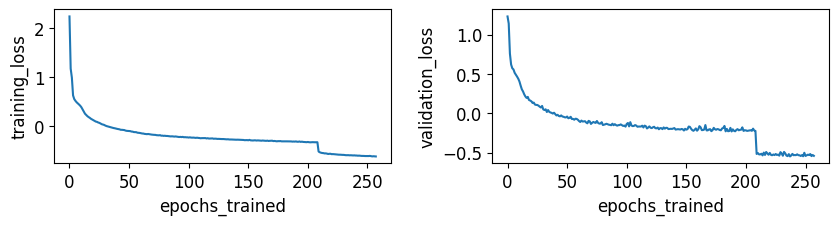

In [61]:
from sbi.analysis import plot_summary
_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

In [62]:
posterior2 = inference.build_posterior()
print(posterior2)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [63]:
samples2 = posterior2.sample((1_000_000,), x=x_obs)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

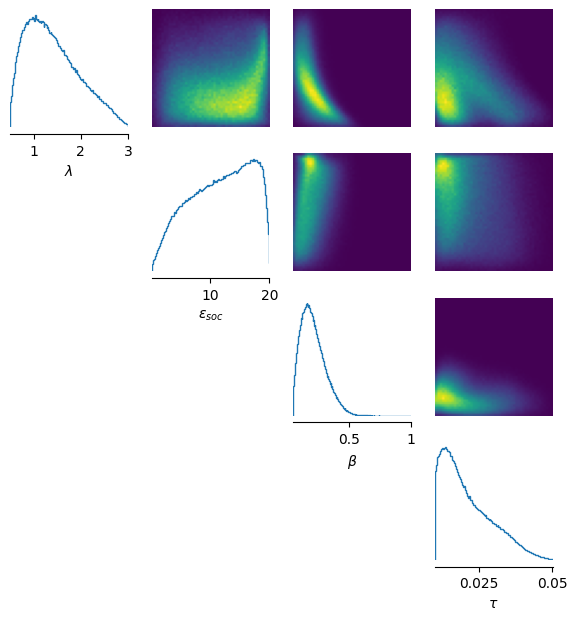

In [64]:
_ = pairplot(
    [samples2],
    limits=limits,
    figsize=(7, 7),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
)

## Identify top matching parameter sets

In [282]:
from tqdm import tqdm
def identify_matching_regions(posterior_samples, n_sim, empirical_trajectory, distance_metric='rmse', top_k=100):

    # sim_outputs = []
    # for params in tqdm(posterior_samples):
    #     theta = torch.as_tensor([params for _ in range(n_sim)])
    #     sim_outputs.append(parallel_simulate(theta).mean(axis=0, keepdims=True))
    # simulated_trajectories = np.vstack(sim_outputs)
    # print(simulated_trajectories.shape)
    simulated_trajectories = parallel_simulate(posterior_samples)
    
    # Compute distance
    if distance_metric == 'rmse':
        distances = np.sqrt(np.mean((simulated_trajectories - empirical_trajectory[None, :])**2, axis=1))
    elif distance_metric == 'corr':
        distances = np.array([
            np.corrcoef(traj, empirical_trajectory)[0,1]
            for traj in simulated_trajectories
        ])
        # For correlation, larger is better, so take largest
        top_indices = np.argsort(-distances)[:top_k]
    else:
        raise NotImplementedError
    if distance_metric == 'rmse':
        top_indices = np.argsort(distances)[:top_k]
    # Select best-matching parameter sets
    best_params = posterior_samples[top_indices]
    best_trajectories = simulated_trajectories[top_indices]
    return best_params, best_trajectories

def run_posterior_predictive(
    param_sets,
    labels=None,
    n_sim=200,
    observed_data=None,
    obs_label="data"
):
    dfs = []
    if labels is None:
        labels = [f"{s}" for s in param_sets]
    for params, label in zip(param_sets, labels):
        theta = torch.as_tensor([params for _ in range(n_sim)])
        sim_outputs = parallel_simulate(theta)
        df = pd.DataFrame(sim_outputs)
        df_melt = df.melt(var_name="trial", value_name="reward")
        df_melt["set"] = label
        dfs.append(df_melt)
    if observed_data is not None:
        df_orig = observed_data.copy()
        df_orig["set"] = obs_label
        dfs = [df_orig] + dfs
    result_df = pd.concat(dfs, ignore_index=True)
    return result_df

In [283]:
%%time
best_params, best_trajectories = identify_matching_regions(samples[:1_000, :], 1, x_obs.values, top_k=10)

/Users/valery/SIOI/Spatial-MAB-ABM/abm/rewards.py:158: UserWarning: Could not sample child maps with desired correlations within 1000 attempts (tol=0.1). Using the last draw.
  warnings.warn(
/Users/valery/Library/Caches/pypoetry/virtualenvs/spatial-mab-abm-icOMRY7y-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 3.97 s, sys: 951 ms, total: 4.92 s
Wall time: 8min 42s


In [284]:
best_trajectories.shape

(10, 15)

[1.176, 11.881, 0.729, 0.023],
[1.180, 18.265, 0.662, 0.044],
[1.593, 11.099, 0.714, 0.034],
[1.296, 10.499, 0.739, 0.022],
[1.048, 7.427, 0.719, 0.021],
[1.101, 16.082, 0.711, 0.034],
[1.322, 9.820, 0.766, 0.014],
[1.042, 10.875, 0.739, 0.023],
[1.128, 4.371, 0.641, 0.044],
[1.091, 9.080, 0.767, 0.021],


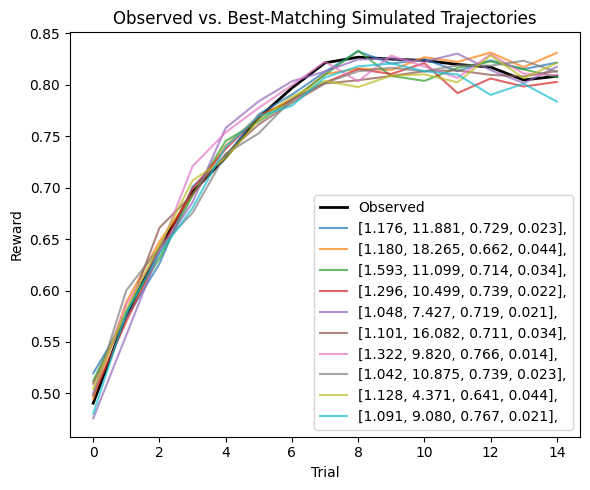

In [285]:
plt.figure(figsize=(6, 5))

# Plot empirical data
plt.plot(x_obs.values, color='black', linewidth=2, label='Observed')

# Plot top matching simulated trajectories
for par, traj in zip(best_params, best_trajectories):
    par_str = "[" + ", ".join(f"{v:.3f}" for v in par) + "],"
    print(par_str)
    plt.plot(traj, alpha=0.7, label=f'{par_str}')

plt.xlabel('Trial')
plt.ylabel('Reward')
plt.title('Observed vs. Best-Matching Simulated Trajectories')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: xlabel='trial', ylabel='reward'>

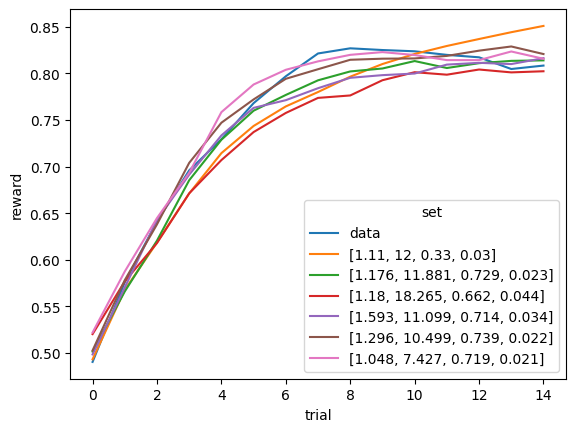

In [291]:
param_sets = [
        [1.11, 12, 0.33, 0.03],
[1.176, 11.881, 0.729, 0.023],
[1.180, 18.265, 0.662, 0.044],
[1.593, 11.099, 0.714, 0.034],
[1.296, 10.499, 0.739, 0.022],
[1.048, 7.427, 0.719, 0.021],
]

df_ppc = run_posterior_predictive(param_sets, None, n_sim=5, observed_data=subj_data_all, obs_label="data")
sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

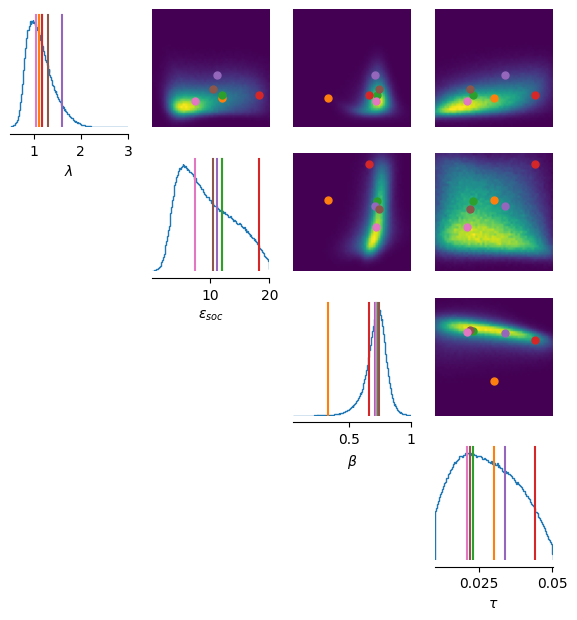

In [287]:
_ = pairplot(
    [samples],
    limits=limits,
    points=param_sets[:],
    figsize=(7, 7),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"],
    fig_kwargs={"points_colors": ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']}
)

<Axes: xlabel='trial', ylabel='reward'>

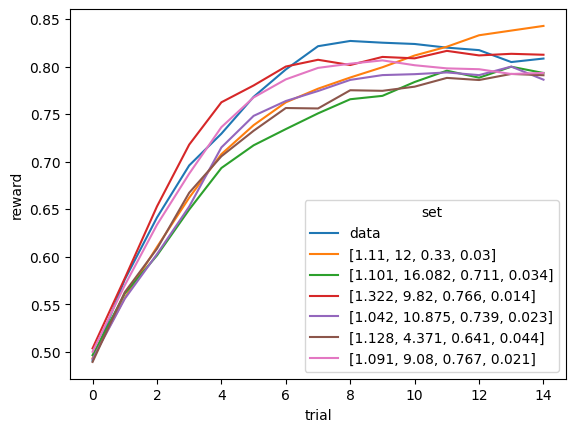

In [328]:
param_sets = [
        [1.11, 12, 0.33, 0.03],
[1.101, 16.082, 0.711, 0.034],
[1.322, 9.820, 0.766, 0.014],
[1.042, 10.875, 0.739, 0.023],
[1.128, 4.371, 0.641, 0.044],
[1.091, 9.080, 0.767, 0.021]
]

df_ppc = run_posterior_predictive(param_sets, None, n_sim=5, observed_data=subj_data_all, obs_label="data")
sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

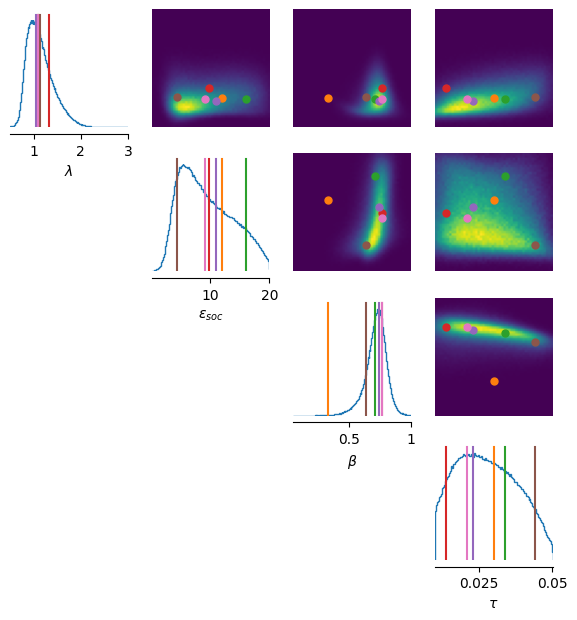

In [331]:
_ = pairplot(
    [samples],
    limits=limits,
    points=param_sets,
    figsize=(7, 7),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"],
    fig_kwargs={"points_colors": ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']}
)

## Posterior Predictive Checks

<Axes: xlabel='trial', ylabel='reward'>

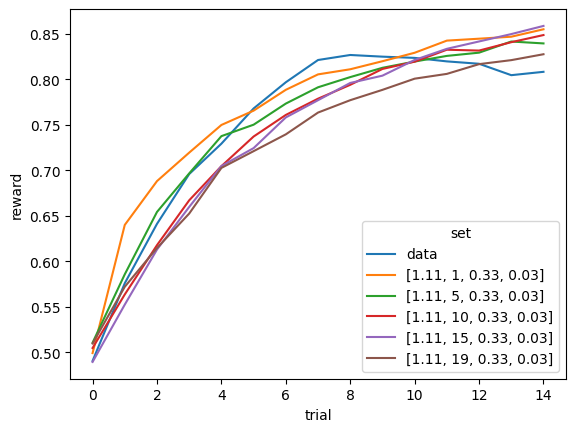

In [327]:
param_sets = [
    [1.11, 1,  0.33, 0.03],
    [1.11, 5,  0.33, 0.03],
    [1.11, 10, 0.33, 0.03],
    [1.11, 15, 0.33, 0.03],
    [1.11, 19, 0.33, 0.03],
]


df_ppc = run_posterior_predictive(param_sets, None, n_sim=3, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

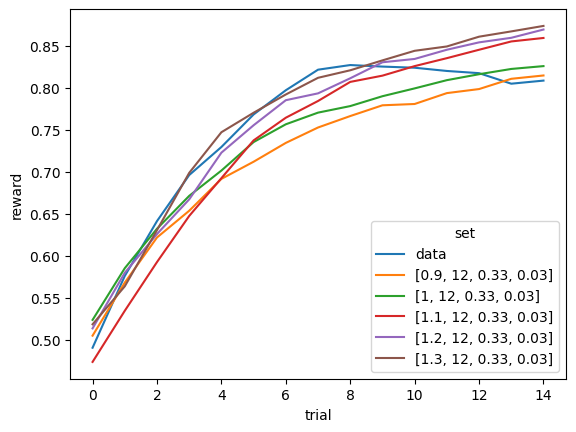

In [325]:
param_sets = [
    [0.9, 12,  0.33, 0.03],
    [1, 12,  0.33, 0.03],
    [1.1, 12, 0.33, 0.03],
    [1.2, 12, 0.33, 0.03],
    [1.3, 12, 0.33, 0.03],
]


df_ppc = run_posterior_predictive(param_sets, None, n_sim=3, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

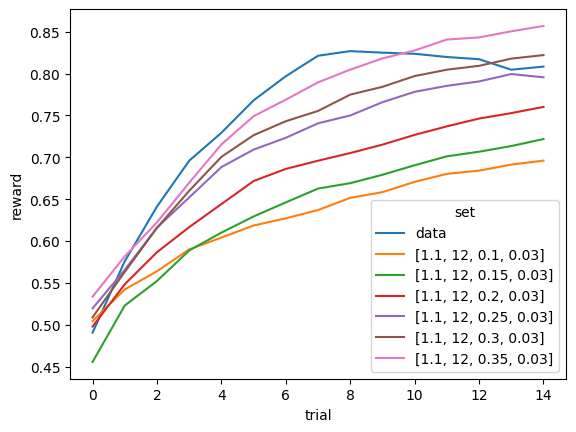

In [324]:
param_sets = [
    [1.1, 12,  0.1, 0.03],
    [1.1, 12,  0.15, 0.03],
    [1.1, 12,  0.2, 0.03],
    [1.1, 12,  0.25, 0.03],
    [1.1, 12,  0.3, 0.03],
    [1.1, 12,  0.35, 0.03],
]


df_ppc = run_posterior_predictive(param_sets, None, n_sim=3, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

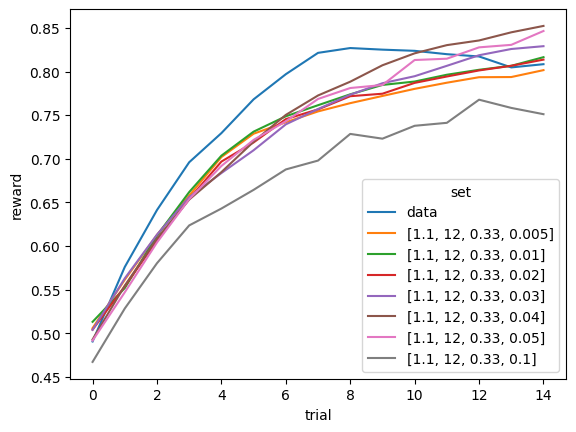

In [326]:
param_sets = [
    [1.1, 12,  0.33, 0.005],
    [1.1, 12,  0.33, 0.01],
    [1.1, 12,  0.33, 0.02],
    [1.1, 12,  0.33, 0.03],
    [1.1, 12,  0.33, 0.04],
    [1.1, 12,  0.33, 0.05],
    [1.1, 12,  0.33, 0.1],
]


df_ppc = run_posterior_predictive(param_sets, None, n_sim=3, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

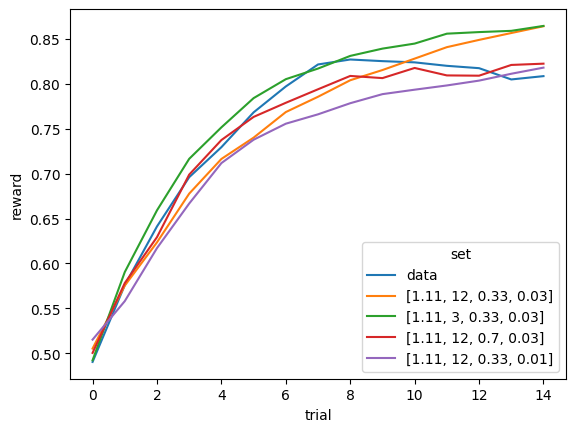

In [321]:
param_sets = [
    [1.11, 12, 0.33, 0.03],
    [1.11, 3, 0.33, 0.03],
    [1.11, 12, 0.7, 0.03],
    [1.11, 12,  0.33, 0.01],
]


df_ppc = run_posterior_predictive(param_sets, None, n_sim=3, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

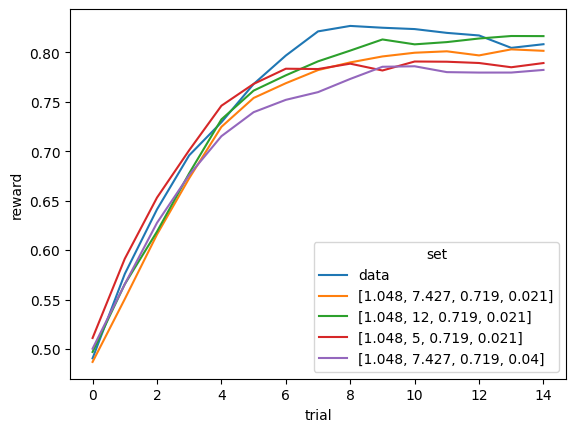

In [339]:

param_sets = [
    [1.048, 7.427, 0.719, 0.021],
    [1.048, 12, 0.719, 0.021],
    [1.048, 5, 0.719, 0.021],
    [1.048, 7.427, 0.719, 0.04],
]


df_ppc = run_posterior_predictive(param_sets, None, n_sim=7, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

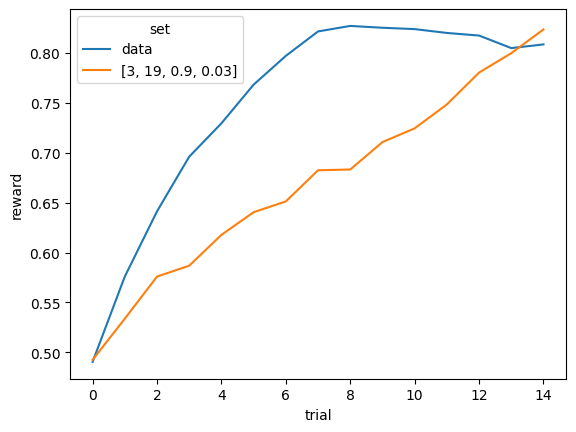

In [334]:
param_sets = [
    [3, 19,  0.9, 0.03],
]
df_ppc = run_posterior_predictive(param_sets, None, n_sim=5, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

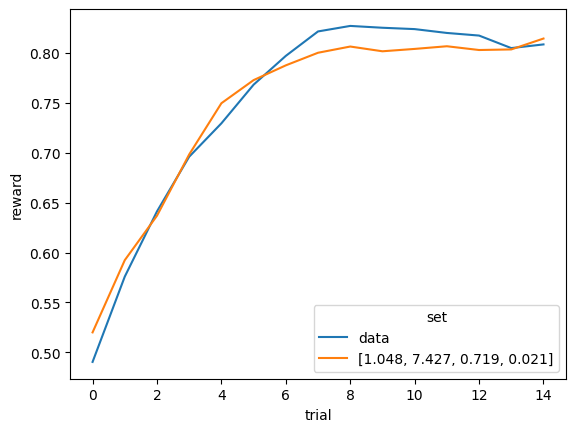

In [335]:
param_sets = [
    [1.048, 7.427, 0.719, 0.021],
]
df_ppc = run_posterior_predictive(param_sets, None, n_sim=5, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

<Axes: xlabel='trial', ylabel='reward'>

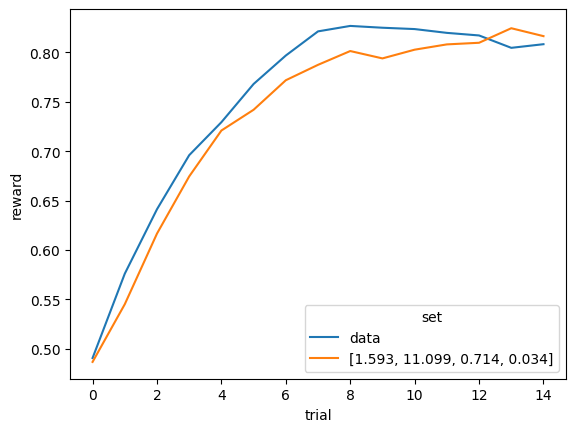

In [336]:
param_sets = [
    [1.593, 11.099, 0.714, 0.034],
]
df_ppc = run_posterior_predictive(param_sets, None, n_sim=5, observed_data=subj_data_all, obs_label="data")

sns.lineplot(df_ppc, x="trial", y="reward", hue="set", errorbar=None)

## Clustering group reward curves

In [292]:
subj_data_all = pd.read_csv("data/e1_data.csv")

In [293]:
group_data = subj_data_all.groupby(["trial", "group"], as_index=False)["reward"].mean()  # , "round"

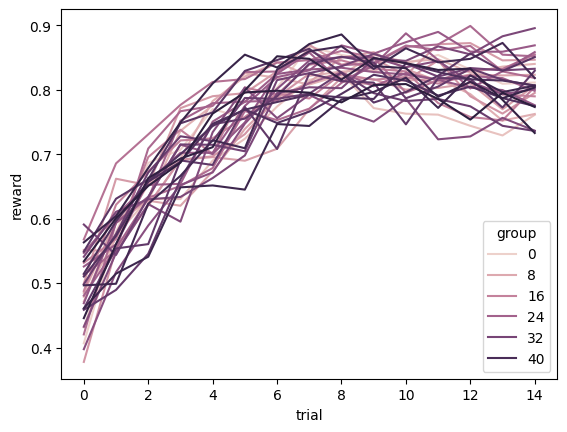

In [294]:
sns.lineplot(group_data, x="trial", y="reward", hue="group");

In [295]:
timeseries_data_df = subj_data_all.pivot_table(index=['group', 'round'], columns='trial', values='reward')
timeseries_data_df.head()

trial              0         1         2         3         4         5   \
group round                                                               
0     0      0.349225  0.542025  0.710975  0.444750  0.827775  0.694150   
      1      0.536125  0.547175  0.689700  0.510775  0.657975  0.659625   
      2      0.413625  0.473550  0.619525  0.785375  0.734250  0.736850   
      3      0.632875  0.596225  0.829750  0.804575  0.844750  0.782450   
      4      0.285600  0.529050  0.493150  0.776050  0.852125  0.807450   

trial              6         7         8         9         10        11  \
group round                                                               
0     0      0.793625  0.807825  0.870175  0.814200  0.850525  0.820800   
      1      0.722650  0.961000  0.874850  0.916925  0.831325  0.867400   
      2      0.821100  0.820500  0.890525  0.958550  0.948375  0.985500   
      3      0.892425  0.857550  0.898725  0.913850  0.849200  0.851200   
      4      0.833850  0.865375  0.876900  0.896175  0.828550  0.822825   

trial              12        13        14  
group round                                
0     0      0.702900  0.840150  0.800725  
      1      0.756350  0.746775  0.825375  
      2      0.886275  0.853950  0.838900  
      3      0.926425  0.860125  0.876025  
      4      0.831625  0.865225  0.785425

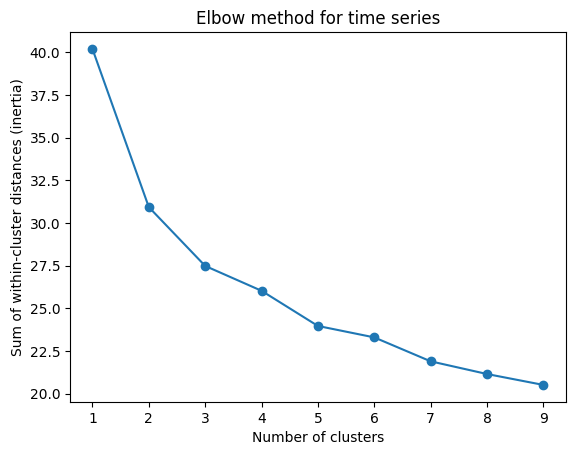

In [296]:
# from tslearn.clustering import TimeSeriesKMeans
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans


timeseries_data = timeseries_data_df.values

# Normalize each timeseries
# scaler = TimeSeriesScalerMeanVariance()
# X_scaled = scaler.fit_transform(timeseries_data)
X_scaled = timeseries_data

inertia = []
k_range = range(1, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=0)  # , metric="dtw"
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker="o")
plt.xlabel('Number of clusters')
plt.ylabel('Sum of within-cluster distances (inertia)')
plt.title('Elbow method for time series')
plt.show()

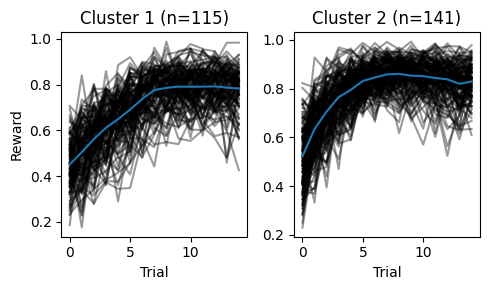

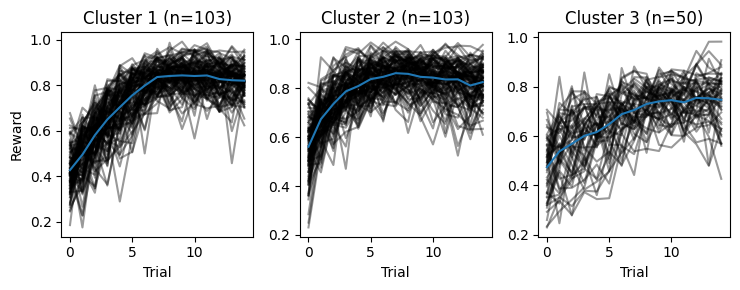

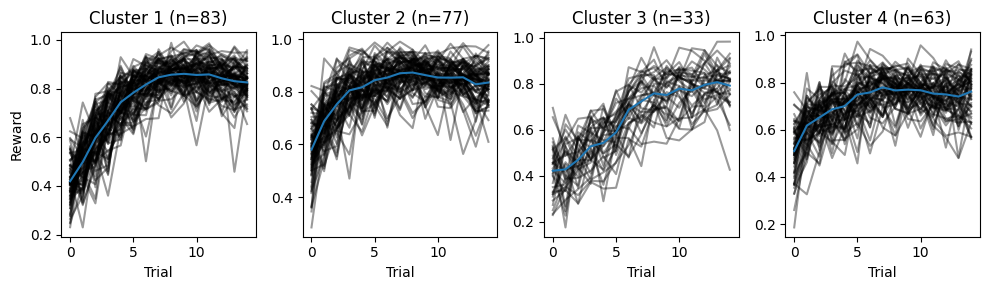

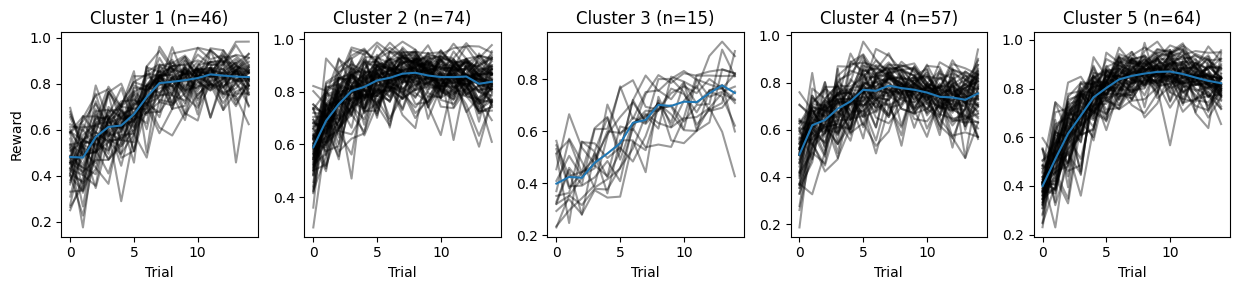

In [300]:
x_obs_clusters_all = []
for k in range(2, 6):

    x_obs_clusters = []

    n_clusters = k
    
    # DTW KMeans clustering
    km = KMeans(n_clusters=n_clusters, random_state=42)  # , metric="euclidean"
    labels = km.fit_predict(X_scaled)
    
    
    plt.figure(figsize=(2.5 * n_clusters, 3))
    
    # X_original = scaler.inverse_transform(X_scaled)
    
    for yi in range(n_clusters):
        plt.subplot(1, n_clusters, yi + 1)  # 1 row, n_clusters columns
        for xx in timeseries_data[labels == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.4)
        # plt.plot(km.cluster_centers_[yi].ravel(), "r-", lw=2)
        cluster_mean = timeseries_data[labels == yi].mean(axis=0)
        x_obs_clusters.append(cluster_mean)
        plt.plot(cluster_mean)
        plt.title(f"Cluster {yi + 1} (n={np.sum(labels == yi)})")
        plt.xlabel('Trial')
        if yi == 0:
            plt.ylabel('Reward')
    plt.tight_layout()
    plt.show()
    
    x_obs_clusters_all.append(x_obs_clusters)

## Fit curves with SBI

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

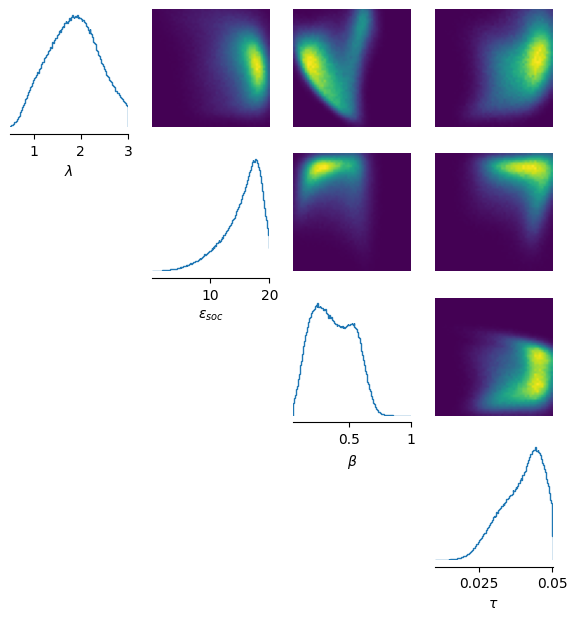

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

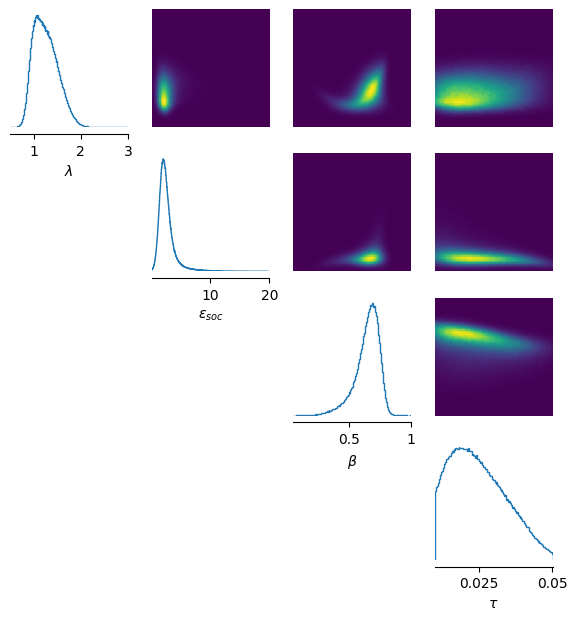

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

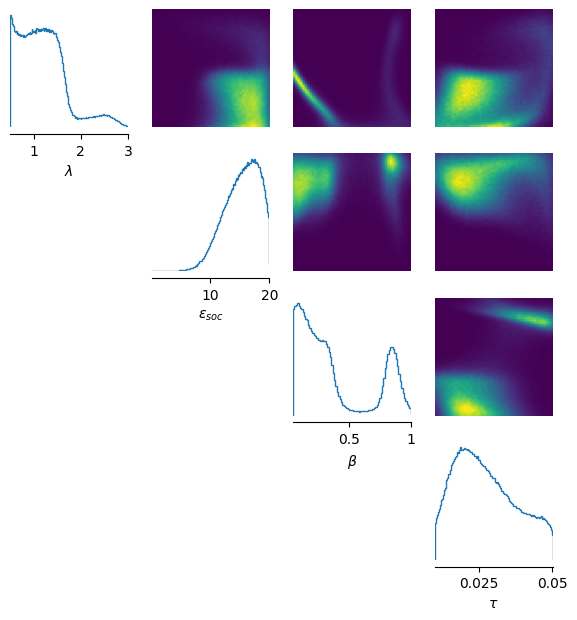

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

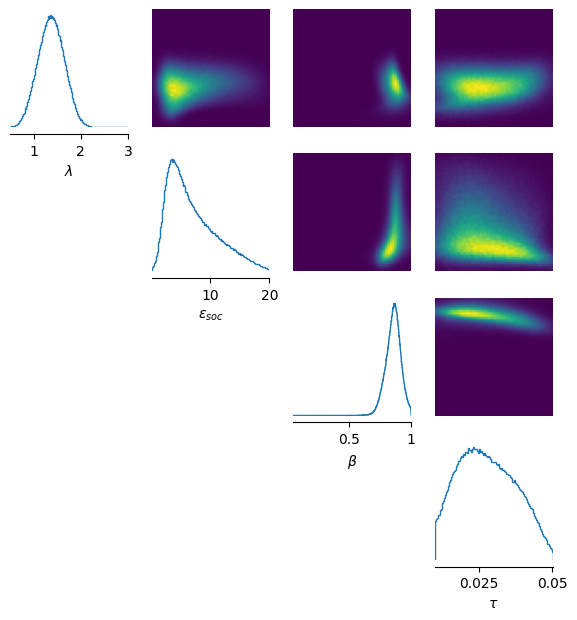

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

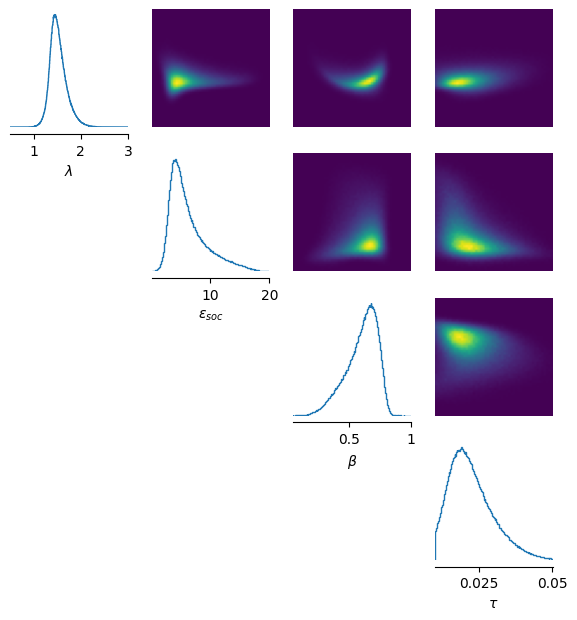

In [298]:
for c_m in x_obs_clusters_all[-1]:
    samples = posterior.sample((1_000_000,), x=c_m)
    
    _ = pairplot(
        [samples],
        limits=limits,
        figsize=(7, 7),
        labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
    )
    plt.show()

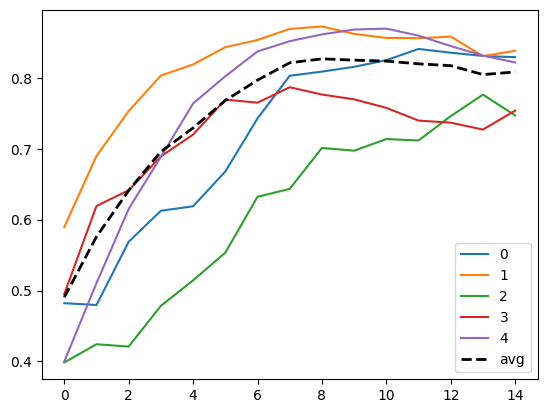

In [299]:
for i, c in enumerate(x_obs_clusters_all[-1]):
    plt.plot(c, label=f'{i}')
plt.plot(x_obs, label='avg', color='k', lw=2, ls='--')
plt.legend()
plt.show()

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

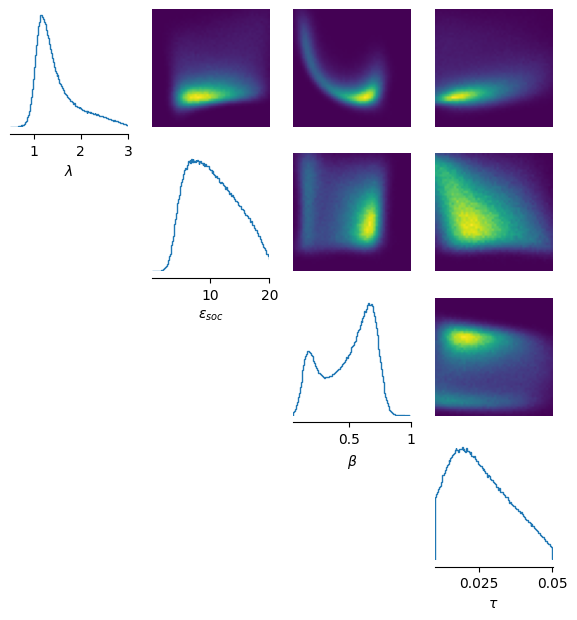

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

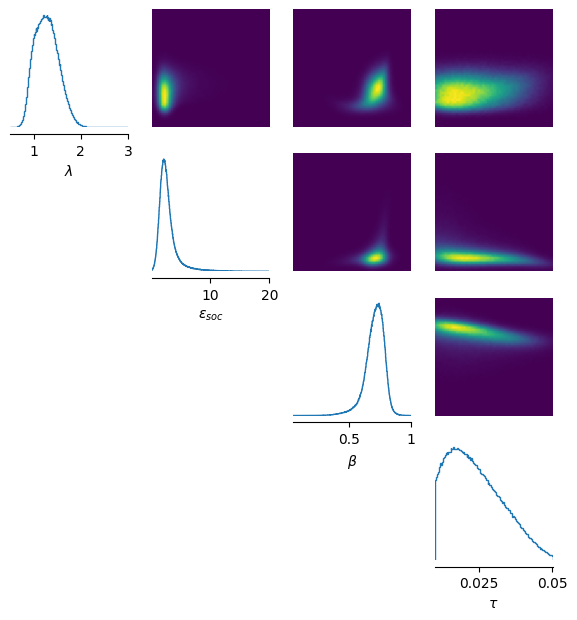

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

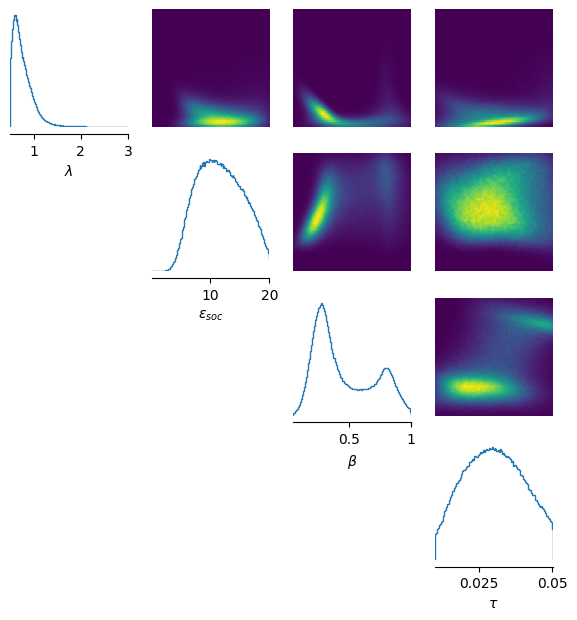

In [301]:
for c_m in x_obs_clusters_all[1]:
    samples = posterior.sample((1_000_000,), x=c_m)
    
    _ = pairplot(
        [samples],
        limits=limits,
        figsize=(7, 7),
        labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
    )
    plt.show()

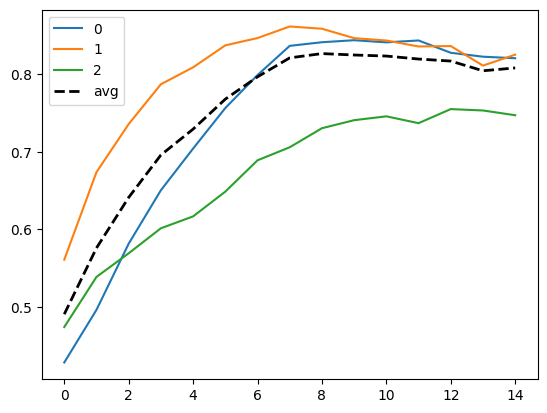

In [302]:
for i, c in enumerate(x_obs_clusters_all[1]):
    plt.plot(c, label=f'{i}')
plt.plot(x_obs, label='avg', color='k', lw=2, ls='--')
plt.legend()
plt.show()